In [ ]:
import torch

from tqdm import tqdm
x = torch.cat((torch.randn(2000, 2),torch.randn(1500, 2)+13,torch.mm(torch.randn(1000, 2)+6,3*(torch.rand(2,2)-0.2))),0)
x # 2D plane

tensor([[ 0.6528, -0.8448],
        [-0.7423,  0.4280],
        [-1.0226,  2.2944],
        ...,
        [17.2716, -0.0499],
        [13.5834,  0.4763],
        [15.2199, -0.5576]])

In [ ]:
import torch
import time
from tqdm import tqdm

# https://wei2624.github.io/MachineLearning/usv_kmeans/
# https://stackoverflow.com/questions/56168482/how-to-convert-some-tensorflow-code-into-pytorch-version
# https://github.com/google-research/google-research/blob/master/yoto/optimizers/yoto.py
# https://www.python-engineer.com/courses/mlfromscratch/12_kmeans/
# https://discuss.pytorch.org/t/k-means-loss-calculation/22041


class KMEANS:
    def __init__(self, n_clusters=50, max_iter=None, verbose=True):
        self.n_clusters = n_clusters
        self.labels = None  # W shape: [x.shape[0],n_cluster] --- discrete: 0/1 --> differentable: prob matrix
        self.dists = None   # D shape: [x.shape[0],n_cluster]
        self.centers = None # center coordinates - (n_clusters,x.shape[1]) = (n_clusters,2)
        self.variation = torch.Tensor([float("Inf")])
        self.verbose = verbose
        self.started = False
        self.max_iter = max_iter
        self.count = 0
        self.loss = torch.empty(0,2)

    def fit(self, x):
        # Randomly select the initial center point, for faster convergence speed, use kmeans++ initialization method in sklearn
        init_cluster_index = torch.randint(0, x.shape[0], (self.n_clusters,))        # torch.randint(low=0, high, size) - init cluster index
        init_clusters = x[init_cluster_index] 
        self.centers = init_clusters
        while True:
            # compute distance to all cluster centers
            self.nearest_center(x)
            # Update center point
            self.update_center(x)
            if self.verbose:
                print(self.variation, torch.argmin(self.dists, (0)))      # index of min - keep row dim
            if torch.abs(self.variation) < 1e-2 and self.max_iter is None:
                break
            elif self.max_iter is not None and self.count == self.max_iter:
                break
            self.count += 1                       # num interation
            print("Finished " + str(self.count) +" iterations.")

    def nearest_center(self, x):
        labels = torch.zeros((x.shape[0],self.centers.shape[0]))                    # discrete: 0/1 --> differentable: prob matrix
        dists = torch.zeros((0, self.n_clusters))                                   # rebuild distance matrix
        current_loss = 0
        for i, sample in enumerate(x):
            dist = torch.sum(torch.mul(sample - self.centers, sample - self.centers), (1))  
            cluster_index = torch.argmin(dist)                        # take index of min dist = cluster index - assign sample to cluster
            labels[i][cluster_index] = 1
            dists = torch.cat([dists, dist.unsqueeze(0)], (0))        # keep row = num of cluster centers
            current_loss = current_loss + torch.sum(torch.mul(labels[i],dist))
        loss_epoch = torch.tensor([[current_loss,self.count]])           # pack current_loss & epoch together 
        self.loss = torch.cat([self.loss, loss_epoch])                   # concat to loss tensor - [current_loss,self.count]

        self.labels = labels  # update labels for points - matrix W 
        if self.started:
            self.variation = torch.sum(self.dists - dists)
        self.dists = dists
        self.started = True

#----------------------------------CHANGE HERE------------------------------------

    def update_center(self, x):
        centers = torch.empty((0, x.shape[1]))                          # center_coords, # dimensions of data --> Autoencoder
        for j in range(self.n_clusters):                                # loop all cluster centers
            cluster_samples = torch.empty((0, x.shape[1]))
            for i in range(x.shape[0]):
              if  self.labels[i][j] == 1:
                cluster_samples = torch.cat([cluster_samples,torch.index_select(x,0,torch.tensor([i]))])
            centers = torch.cat([centers, torch.mean(cluster_samples, (0)).unsqueeze(0)], (0))       # select points in cluster & take mean - differentiable (same formula) 
        self.centers = centers                                          # update center coords
    
    def visualize(self):
      %matplotlib inline
      import matplotlib.pyplot as plt
      import numpy as np

      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
      fig.suptitle('Plotting results')
      loss_term = self.loss.index_select(1, torch.LongTensor([0])).numpy()
      epoch = self.loss.index_select(1, torch.LongTensor([1])).numpy()
      ax1.plot(epoch, loss_term)
      ax1.set_title('Loss w.r.t. epochs')

      x_x=x.index_select(1, torch.LongTensor([0]))
      x_y=x.index_select(1, torch.LongTensor([1]))
      centers_x=self.centers.index_select(1, torch.LongTensor([0]))
      centers_y=self.centers.index_select(1, torch.LongTensor([1]))
      ax2.scatter(x_x,x_y, marker='+',)
      ax2.scatter(centers_x,centers_y,marker='.', color='black')
      ax2.set_title('Data & cluster centers')

Finished 1 iterations.
Finished 2 iterations.
Finished 3 iterations.
Finished 4 iterations.
Finished 5 iterations.
Finished 6 iterations.
Finished 7 iterations.
Finished 8 iterations.
Finished 9 iterations.
Finished 10 iterations.
Finished 11 iterations.
Finished 12 iterations.
Finished 13 iterations.
Finished 14 iterations.
Finished 15 iterations.
Finished 16 iterations.
Finished 17 iterations.
Finished 18 iterations.
Finished 19 iterations.
Finished 20 iterations.
Finished 21 iterations.
Finished 22 iterations.
Finished 23 iterations.
Finished 24 iterations.
Finished 25 iterations.
Finished 26 iterations.
Finished 27 iterations.
Finished 28 iterations.
Finished 29 iterations.
Finished 30 iterations.
Finished 31 iterations.
Finished 32 iterations.
Finished 33 iterations.
Finished 34 iterations.
Finished 35 iterations.
Finished 36 iterations.
Finished 37 iterations.
Finished 38 iterations.
Finished 39 iterations.
Finished 40 iterations.
Finished 41 iterations.
Finished 42 iterations.
F

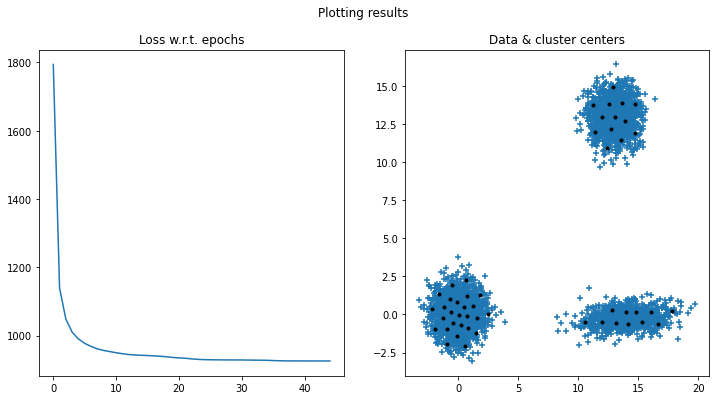

In [ ]:
k = KMEANS(n_clusters=50,max_iter=70,verbose=False)
k.fit(x)
k.visualize()